In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
#######################################################################
# Copyright (C)                                                       #
# 2017 Cheung Auyeung (yellowlab9@gmail.com)                          #                        
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

# Chapter 2

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time 

In [3]:
figureIndex = 0

In [4]:
class Bandit:
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @stepSize: constant step size for updating estimations
    # @sampleAverages: if True, use sample averages to update estimations 
    #                  instead of constant step size
    # @UCB: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradientBaseline: if True, use average reward as baseline for gradient 
    #                    based bandit algorithm
    def __init__(self, kArm=10, epsilon=0., initial=0., stepSize=0.1, sampleAverages=False, 
                 UCBParam=None, gradient=False, gradientBaseline=False, trueReward=0.):
        self.k = kArm
        self.stepSize = stepSize
        self.sampleAverages = sampleAverages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCBParam = UCBParam
        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        self.averageReward = 0
        self.trueReward = trueReward

        # real reward for each action
        self.qTrue = []

        # estimation for each action
        self.qEst = np.zeros(self.k)

        # # of chosen times for each action
        self.actionCount = []

        self.epsilon = epsilon

        # initialize real rewards with N(0,1) distribution and estimations with 
        # desired initial value
        for i in range(0, self.k):
            self.qTrue.append(np.random.randn() + trueReward)
            self.qEst[i] = initial
            self.actionCount.append(0)

        self.bestAction = np.argmax(self.qTrue)

    # get an action for this bandit, explore or exploit?
    def getAction(self):
        # explore
        if self.epsilon > 0:
            if np.random.binomial(1, self.epsilon) == 1:
                np.random.shuffle(self.indices)
                return self.indices[0]

        # exploit
        if self.UCBParam is not None:
            UCBEst = self.qEst + 
                self.UCBParam * np.sqrt(np.log(self.time + 1) / 
                                                        (np.asarray(self.actionCount) + 1))
            return np.argmax(UCBEst)
        elif self.gradient:
            expEst = np.exp(self.qEst)
            self.actionProb = expEst / np.sum(expEst)
            return np.random.choice(self.indices, p=self.actionProb)
        else:
            return np.argmax(self.qEst)

    # take an action, update estimation for this action
    def takeAction(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.qTrue[action]
        self.time += 1
        self.averageReward = (self.time - 1.0) / self.time * self.averageReward + 
                                                                            reward / self.time
        self.actionCount[action] += 1

        if self.sampleAverages:
            # update estimation using sample averages
            self.qEst[action] += 1.0 / self.actionCount[action] * (reward - self.qEst[action])
        elif self.gradient:
            oneHot = np.zeros(self.k)
            oneHot[action] = 1
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0
            self.qEst = self.qEst + 
                            self.stepSize * (reward - baseline) * (oneHot - self.actionProb)
        else:
            # update estimation with constant step size
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

In [5]:
def banditSimulation(nBandits, time, bandits):
    bestActionCounts = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    averageRewards = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    for banditInd, bandit in enumerate(bandits):
        for i in range(0, nBandits):
            for t in range(0, time):
                action = bandit[i].getAction()
                reward = bandit[i].takeAction(action)
                averageRewards[banditInd][t] += reward
                if action == bandit[i].bestAction:
                    bestActionCounts[banditInd][t] += 1
        bestActionCounts[banditInd] /= nBandits
        averageRewards[banditInd] /= nBandits
    return bestActionCounts, averageRewards

## Figure 2.1
An exemplary bandit problem from the 10-armed testbed. The true value $q_\ast(a)$ of each of the ten actions $a$,

$$
q_\ast(a) = E\left[ R_t \,|\, A_t = a\right] \qquad, 
$$

was selected according to a normal distribution around zero mean with
unit variance, and then the actual rewards $R_t$ of the action $a$ 
were selected according to a normal distribution around 
mean $q_\ast(a)$ with unit variance, as
suggested by the colored distributions in the following figure.


In [6]:
def figure2_1():
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    sns.violinplot(data=np.random.randn(200,10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.yticks(np.arange(-6, 5, 1.0))

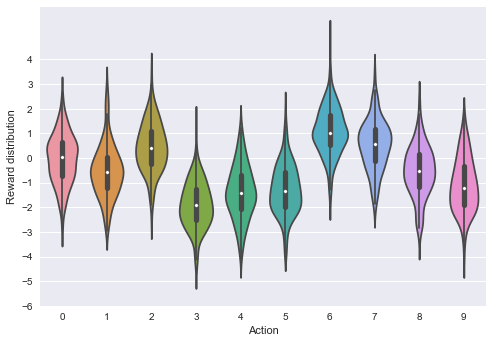

In [7]:
np.random.seed(seed=100)
figure2_1()
plt.show()

A python decorator to time the elapse time of a function call.

In [8]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print('%r  %2.2f s' % \
            (method.__name__, (te - ts) ))
        return result

    return timed

## Figure 2.2  Estimation of Reward by Sample-Average
Figure 2.2 compares a greedy method ($\epsilon = 0$) with two $\epsilon$-greedy methods ($\epsilon = 0.01$ and
$\epsilon = 0.1$), on the 10-armed testbed. For the two $\epsilon$-greedy methods, the sample-average technique is used to estimate the action-value.

The sample-average technique estimates the reward $Q_t(a)$ based on the past history.

$$
\begin{align}
Q_t(a) \,\overset{.}{=}&\, \frac
{\text{sum of rewards when } a \text{ taken prior to } t}
{\text{number of times } a \text{ taken prior to } t} \\
{}\,=&\,
\frac
{\sum_{i=1}^{t-1} R_i \cdot 1_{A_i=a}}
{\sum_{i=1}^{t-1} 1_{A_i=a}}
\end{align}
$$

where $1_{predicate}$ denotes the random variable that is $1$ if predicate is true and $0$ if it is not.

This $Q_t(a)$ can be computed recursively. Since the estimated reward for the same action $a$ repeated $n$ times is 

$$
Q_{n+1} = \frac{R_1+\ldots+R_n}{n}
$$

We have
$$
\begin{align}
    nQ_{n+1} &= R_1+\ldots+R_n \\
             &= (R_1+\ldots+R_{n-1}) + R_n \\
             &= (n-1)Q_n + R_n \\
             &= nQ_n + (R_n - Q_n)
\end{align}
$$

Therefore

$$
    Q_{n+1} = Q_n + \frac{1}{n}\bigg[R_n - Q_n\bigg]
$$

This update method of $Q_{n+1}$ is implemented in the `class Bandit` method `takeAction`  as `self.qEst[action]`:
```python
self.qEst[action] += 
    1.0 / self.actionCount[action] * (reward - self.qEst[action])
```

This greedy action selection method can be written as

$$
A_t \,\overset{.}{=}\, \underset{a}{\mathrm{argmax}}\, Q_t(a)
$$

It is implemented in the `class Bandit` method `getAction`  as
```python
return np.argmax(self.qEst)
```

In [9]:
@timeit
def epsilonGreedy(nBandits, nSteps):
    epsilons = [0.1, 0.01, 0.]

    # default parameters of Bandit:
    # kArm=10, epsilon=0., initial=0., stepSize=0.1, trueReward=0. 
    # sampleAverages=False, UCBParam=None, gradient=False, gradientBaseline=False 
    bandits = []
    for epsInd, eps in enumerate(epsilons):
        bandits.append([Bandit(epsilon=eps, sampleAverages=True) for _ in range(0, nBandits)])
        
    bestActionCounts, averageRewards = banditSimulation(nBandits, nSteps, bandits)
    
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, counts in zip(epsilons, bestActionCounts):
        plt.plot(counts*100., label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, rewards in zip(epsilons, averageRewards):
        plt.plot(rewards, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('average reward')
    plt.legend()

'epsilonGreedy'  186.98 s


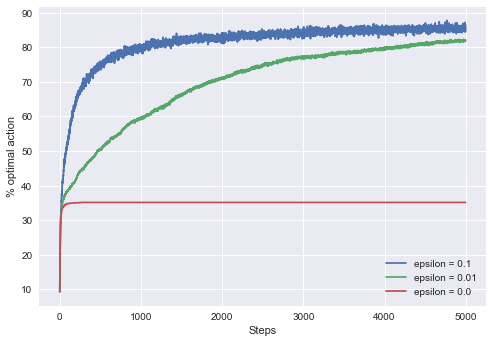

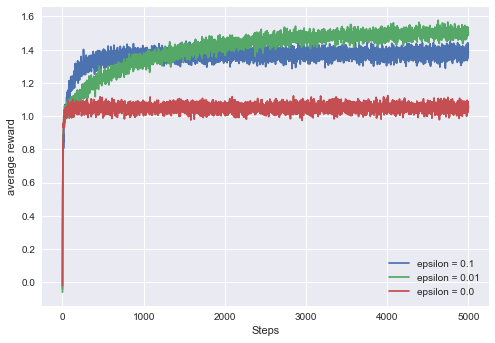

In [10]:
np.random.seed(seed=40)
epsilonGreedy(2000, 5000)
plt.show()

## Figure 2.3 Optimisic Intial Value $Q_1(a)$

Figure 2.3 shows the performance on the 10-armed bandit testbed of a greedy
method using $Q_1(a) = +5$, for all $a$. For comparison, also shown is an $\epsilon$-greedy
method with $Q_1(a) = 0$.   A $Q_1(a) = 5$ value is widely optimistic and it encourages action-value method to explore. 

Both methods use a constant step-size parameter $\alpha \in (0,1]$ for updating an average $Q_n$ of the $n-1$ past rewards as the following:
$$
    Q_{n+1} = Q_n + \alpha\big[R_n - Q_n\big]
$$

This update method of $Q_{n+1}$ is implemented in the `class Bandit` method `takeAction`  as `self.qEst[action]`:
```python
self.qEst[action] += self.stepSize * (reward - self.qEst[action])
```

This greedy action selection method is also used in Figure 2.3. It can be written as

$$
A_t \,\overset{.}{=}\, \underset{a}{\mathrm{argmax}}\, Q_t(a)
$$

In [11]:
@timeit
def optimisticInitialValues(nBandits, nSteps):
    # default parameters of Bandit:
    # kArm=10, epsilon=0., initial=0., stepSize=0.1, trueReward=0. 
    # sampleAverages=False, UCBParam=None, gradient=False, gradientBaseline=False
    bandits = [[], []]
    bandits[0] = [Bandit(epsilon=0, initial=5, stepSize=0.1) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(epsilon=0.1, initial=0, stepSize=0.1) for _ in range(0, nBandits)]
    
    bestActionCounts, averageRewards  = banditSimulation(nBandits, nSteps, bandits)
    
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(bestActionCounts[0]*100, label='epsilon = 0, q = 5')
    plt.plot(bestActionCounts[1]*100, label='epsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(averageRewards[0], label='epsilon = 0, q = 5')
    plt.plot(averageRewards[1], label='epsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('average reward')
    plt.legend()

'optimisticInitialValues'  96.27 s


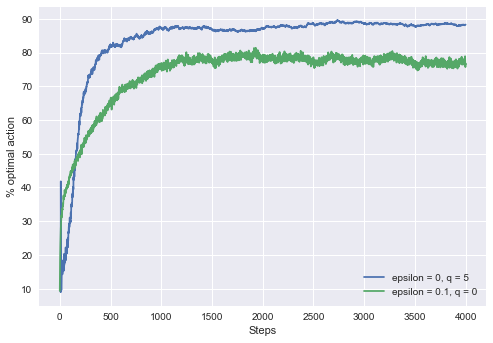

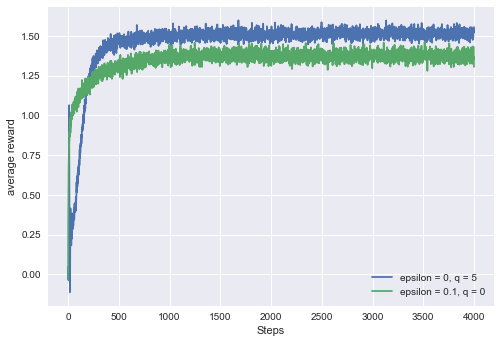

In [12]:
np.random.seed(seed=40)
optimisticInitialValues(2000, 4000)
plt.show()

## Figure 2.4 Upper Confidence Bound (UCB) Action Selection 

Figure 2.4 shows the average performance of upper confidence bound (UCB) action selection on the 10-armed testbed.

UCB select among the non-greedy actions
according to their potential for actually being optimal, taking into account both how
close their estimates are to being maximal and the uncertainties in those estimates as the following:

$$
A_t \,\overset{.}{=}\, \underset{a}{\mathrm{argmax}}\, \left[Q_t(a) + c\sqrt{\frac{\log(t)}{N_t(a)}} \,\right]
$$

where $\log(t)$ denotes the natural logarithm of $t$, $N_t(a)$ denotes the number of 
times that action a has been selected prior to time $t$, and the number
$c > 0$ controls the degree of exploration. If $N_t(a) = 0$, then $a$ is considered to be a
maximizing action. 
The quantity being max’ed over is thus a sort of upper bound on the possible true
value of action $a$, with the $c$ parameter determining the confidence level. 

The idea of this upper confidence bound (UCB) action selection is that the square root term is a measure of the uncertainty or variance in the estimate of $a$’s value.

TheUCB action selection is implemented in the `class Bandit` method `getAction`  as
```python
UCBEst = self.qEst + \
    self.UCBParam * np.sqrt(np.log(self.time + 1) / (np.asarray(self.actionCount) + 1))
return np.argmax(UCBEst)
```
In this vectorized implementation, broacasting from numpy is used for operation between numpy array and scalar value.

Figure 2.4  also uses a constant `stepSize` parameter $\alpha = 0.1$ for updating an average $Q_n$ of the $n−1$
past rewards as the following:
$$
    Q_{n+1} = Q_n + \alpha\big[R_n - Q_n\big]
$$

In [13]:
@timeit
def ucb(nBandits, time):
    # default parameters of Bandit:
    # kArm=10, epsilon=0., initial=0., stepSize=0.1, trueReward=0. 
    # sampleAverages=False, UCBParam=None, gradient=False, gradientBaseline=False    
    bandits = [[], []]
    bandits[0] = [Bandit(epsilon=0, stepSize=0.1, UCBParam=2) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(epsilon=0.1, stepSize=0.1) for _ in range(0, nBandits)]
    
    _, averageRewards = banditSimulation(nBandits, time, bandits)

    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(averageRewards[0], label='UCB c = 2')
    plt.plot(averageRewards[1], label='epsilon greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

'ucb'  41.07 s


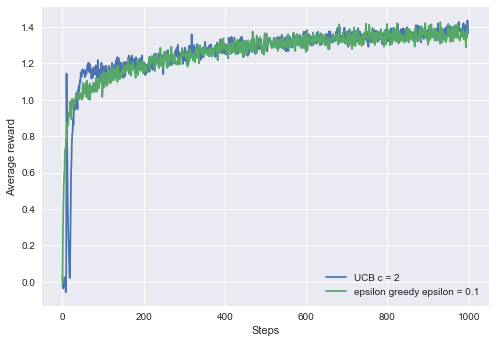

In [14]:
np.random.seed(seed=40)
ucb(2000, 1000)
plt.show()

## Figure 2.5 Stochastic Action Selection by Preferences
Figure 2.5 shows results with the gradient bandit algorithm on a variant of the
10-armed testbed in which the true expected rewards were selected according to a
normal distribution with a mean of +4 instead of zero and with unit variance. 

The gradient bandit algorithm uses preferences to select action instead of the estimated rewards. On each step, after selecting the action $A_t$ and receiving the reward
$R_t$, the preferences are updated by:

$$
\begin{align}
H_{t+1}(A_t) &\,\overset{.}{=}\, H_t(A_t) + \alpha ( R_t − \bar{R}_t)(1 − \pi_t(A_t)), &\qquad &\text{and} \\
H_{t+1}(a)   &\,\overset{.}{=}\, H_t(a)   − \alpha ( R_t − \bar{R}_t)\pi_t(a), &\qquad &\forall a \ne A_t,
\end{align}
$$

The above iteration is a stochastic approximation to gradient ascent. In exact gradient
ascent, each preference $H_t(a)$ would be incrementing proportional to the increment’s effect on performance:

$$
H_{t+1}(a) \,\overset{.}{=}\, H_t(a) + \alpha \frac{\partial E[R_t]}{\partial H_t(a)}
$$

where the measure of performance here is the expected reward:

$$
E[R_t] \,\overset{.}{=}\, \sum_{b} \pi_t(b)q_*(b)
$$

And as a result of stochastic approximation to gradient ascent, we have

$$
\frac{\partial E[R_t]}{\partial H_t(a)} \approx   \left\{
    \begin{array}{l}
      ( R_t − \bar{R}_t)(1 − \pi_t(A_t)) &\qquad \text{if $a = A_t$}\\
      ( R_t − \bar{R}_t)(0 - \pi_t(a))   &\qquad \text{otherwise}
    \end{array}
  \right.
$$

The preferences $H_t(a)$ are used to select an action randomly according to the following distribution:

$$
Pr\left\{A_t = a\right\} \,\overset{.}{=}\,
\frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b}}
\,\overset{.}{=}\, \pi_t(a),
$$

This stochastic action selection is implemented in the `class Bandit` method `getAction`  as
```python
expEst = np.exp(self.qEst)
self.actionProb = expEst / np.sum(expEst)
return np.random.choice(self.indices, p=self.actionProb)
```
where `self.qEst` is reused to store $H_t(a)$ and `self.actionProb` is  $\pi_t(a)$.

The value $H_t(a)$ is updated in `self.qEst[action]` after selecting the action $A_t$ and receiving the `reward`
$R_t$ in in the `class Bandit` method `takeAction` based on $\bar{R}_t$ (`self.averageReward`)
```python
reward = np.random.randn() + self.qTrue[action]
self.time += 1
self.averageReward = (self.time - 1.0) / self.time * self.averageReward + \
    reward / self.time
```
depending whether average reward, $\bar{R}_t$ (`self.averageReward`),  is used for baseline or not:
```python
oneHot = np.zeros(self.k)
oneHot[action] = 1
if self.gradientBaseline:
    baseline = self.averageReward
else:
    baseline = 0
self.qEst = self.qEst + self.stepSize * (reward - baseline) * (oneHot - self.actionProb)
```



In [15]:
@timeit
def gradientBandit(nBandits, time):
    # default parameters of Bandit:
    # kArm=10, epsilon=0., initial=0., stepSize=0.1, trueReward=0. 
    # sampleAverages=False, UCBParam=None, gradient=False, gradientBaseline=False    
    bandits =[[], [], [], []]
    bandits[0] = [Bandit(gradient=True, stepSize=0.1, gradientBaseline=True, trueReward=4) 
                      for _ in range(0, nBandits)]
    bandits[2] = [Bandit(gradient=True, stepSize=0.1, gradientBaseline=False, trueReward=4) 
                      for _ in range(0, nBandits)]
    bandits[1] = [Bandit(gradient=True, stepSize=0.4, gradientBaseline=True, trueReward=4) 
                      for _ in range(0, nBandits)]
    bandits[3] = [Bandit(gradient=True, stepSize=0.4, gradientBaseline=False, trueReward=4) 
                      for _ in range(0, nBandits)]
    bestActionCounts, _ = banditSimulation(nBandits, time, bandits)
    labels = ['alpha = 0.1, with baseline',
              'alpha = 0.4, with baseline',
              'alpha = 0.1, without baseline',
              'alpha = 0.4, without baseline']
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for i in range(0, len(bandits)):
        plt.plot(bestActionCounts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()

'gradientBandit'  240.93 s


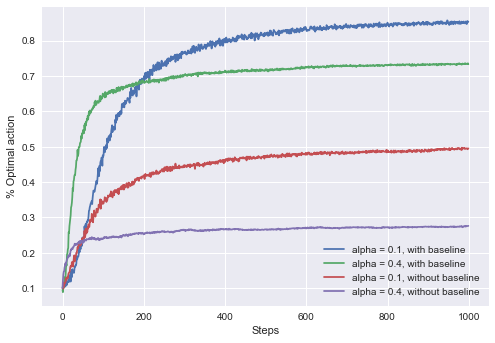

In [16]:
# This will take somehow a long time
np.random.seed(seed=40)
gradientBandit(2000, 1000)
plt.show()

## Figure 2.6 Comparison of Simple Balancing of Exploration and Exploitation 

Figure 2.6 compare the following simple ways of balancing exploration and
exploitation. 
- The $\epsilon$-greedy methods choose randomly a small fraction of the time with the parameter $\epsilon$.
- The UCB methods choose deterministically but achieve exploration by subtly
favoring at each step the actions that have so far received fewer samples 
with the parameter $c>0$ which controls the degree of exploration
- Gradient bandit algorithms estimate not action values, but action preferences, 
and favor the more preferred actions in a graded, probabilistic manner using a soft-max distribution, and a step-size parameter $\alpha > 0$.
- The simple expedient of initializing estimates $Q_0$ optimistically causes even greedy
methods to explore significantly.

Figure 2.6 shows the average rewards as the corresponding parameters, $\epsilon$, $c$, $\alpha$, and $Q_0$ varied by factors of two on a log scale.

In [17]:
@timeit
def figure2_6(nBandits, time):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sampleAverages=True),
                  lambda alpha: Bandit(gradient=True, stepSize=alpha, gradientBaseline=True),
                  lambda coef: Bandit(epsilon=0, stepSize=0.1, UCBParam=coef),
                  lambda initial: Bandit(epsilon=0, initial=initial, stepSize=0.1)]
    parameters = [np.arange(-7, -1),
                  np.arange(-5, 2),
                  np.arange(-4, 3),
                  np.arange(-2, 3)]

    bandits = [[generator(pow(2., param)) for _ in range(0, nBandits)] 
                for generator, parameter in zip(generators, parameters) for param in parameter]
    
    _, averageRewards = banditSimulation(nBandits, time, bandits)
    
    rewards = np.sum(averageRewards, axis=1)/time

    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter(2^x)')
    plt.ylabel('Average reward')
    plt.legend()

'figure2_6'  733.97 s


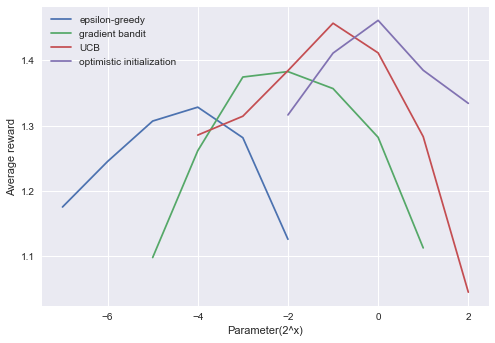

In [18]:
# This will take somehow a long time
np.random.seed(seed=42)
figure2_6(2000, 1000)
plt.show()